# Development Cell type transfer

1. Build a dictionary with cell-types and marker genes
    1. which cell-types?
        1. inital set taken from reference atlas (so you would have cell types even when new data is not labeled yet)
        2. optional: set taken from dataset - or a combination of atlas and dataset
    2. Which marker-genes?
        2. Option 1: provide an input txt file with a set of marker genes per cell type
        3. Option 2: get spatially variational genes from atlas per cell-type
2. iterate over the location point
    1. check which genes are mapped to the location
    1. check which cell-type would be possible for this location based on the genes found
    1. assign one of the possible cell-types randomly
3. repeat step 2 X times
4. per location - assign the cell-type that was assigned most often

## ToDo list

In [1]:
from importlib import reload



import anndata
from bokeh.layouts import column
%matplotlib inline
import novosparc
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
# import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
from scipy.stats import zscore
from sklearn import preprocessing

import random

Data used: Uterus, secretory phase, sample 2 (processing see `extract_sc_dge.ipynb` notebook)

# data read in
## atlas and sc data

In [2]:
# atlas settings
atlas_dir = 'data'
target_space_path = os.path.join(atlas_dir, 'endometr_coordinates.txt')
locations = pd.read_csv(target_space_path, sep='\t')

num_locations = 3871 # coming from the spatial data
locations_apriori = locations[:num_locations][['x', 'y']]
locations = np.asarray(locations_apriori)

atlas_path = os.path.join(atlas_dir, 'uterus_GarciaAlsonso_atlas_spatial_info_dge.csv')
# atlas = sc.read_csv(atlas_path, delimiter=',') # this always through a Value Error about unmatching column numbers - idea why

chunks = pd.read_csv(atlas_path, index_col=0, chunksize=1000000)
df = pd.concat(chunks)
atlas = sc.AnnData(df)
atlas_genes = atlas.var.index.tolist()
atlas.obsm['spatial'] = locations

# Reading expression data to scanpy AnnData (cells x genes)
data_dir = 'data/'
data_path = os.path.join(data_dir, 'adata_ti_sec_2_sample_normalized_dge.csv')
dataset = sc.read(data_path).T
gene_names = dataset.var.index.tolist()
num_cells, num_genes = dataset.shape
print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)

<ipython-input-2-1ab68b74a6b1>:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  atlas = sc.AnnData(df)
/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


number of cells: 2368
number of genes: 28614


# meta data

In [3]:
meta_data_dir = 'data'
meta_ct_path = os.path.join(meta_data_dir, "endo_sec2_celltype.csv")

cell_types_raw = pd.read_csv(meta_ct_path)
cell_type = np.asarray(cell_types_raw)

# Reconstruction
## create tissue object

In [100]:
# calculate cost matrix
# params for smooth cost # only needed when/for the part where you don't use the atlas!
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(gene_names))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)


# setup smooth
num_neighbors_s = num_neighbors_t = 5

# alternative 1: setup both assumptions
tissue.setup_reconstruction(atlas_matrix=atlas_matrix,
                            markers_to_use=markers_to_use,
                            num_neighbors_s=num_neighbors_s,
                            num_neighbors_t=num_neighbors_t)

# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

Setting up for reconstruction ... 

/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


done ( 21.28 seconds )
Reconstructing spatial information with 77 markers: 2368 cells and 3871 locations ... 
Trying with epsilon: 5.00e-03
Trying with epsilon: 5.00e-03


In [101]:
tissue.obsm['spatial'] = locations

AttributeError: 'Tissue' object has no attribute 'obsm'

# meta data transfer
## prepare gw matrix

In [5]:
gw_matrix = pd.DataFrame(tissue.gw)
type(gw_matrix)
gw_matrix.shape[0]

2368

Assumption: cell type assignment is a binary mapping.
Therefor for each cell I only want the location with the highest probability - the rest 0.

Later I will encode the cell types as integers.
Then I can multiply the ct_int_matrix with the highest_probability_gw_matrix.
But then?

**Create highest probability matrix**
1. init a dic for index:value
2. iterate through the rows - identify highest value --> write value and index in dic
3. all zero gw
```
for col in df.columns:
    df[col].values[:] = 0
```
4. fill back the values from the dictionary `df.loc[0:15,'A'] = 16`

or
1. make all-0 df of the same size as gw
2. iterate through rows of gw
3. get max value
4. get index of max value
5. replace 0 in new df at same index with that value

In [ ]:
# make all-0 df of the same size as gw
all_0_df = pd.DataFrame(
             np.zeros(shape=(gw_matrix.shape[0],gw_matrix.shape[1])))

# iterate through rows of gw
# ToDo there must be a vectorized way to do this
# or also in this directory manner like with the GMM function?
for row in gw_matrix.index:
    max_value = max(gw_matrix.loc[row])
    index_value = np.where( gw_matrix == max_value)
    # fill new df
    all_0_df.loc[int(index_value[0]),int(index_value[1])] = max_value

In [ ]:
# every column must have a max value that is non 0 too now - no?
for (columnName, columnData) in all_0_df.iteritems():
        print(max(columnData))

# wait - has max() a decimal limit??

## meta data mapped to location (?)

In [ ]:
cell_types

In [ ]:
meta_data_map = np.dot(cell_types_arr.T, gw_matrix)

In [ ]:
type(cell_types)

# use one-hot encoding

## merge celltype with gw

In [9]:
print(cell_types_raw.shape)
print(gw_matrix.shape)

(2368, 1)
(2368, 3871)


In [ ]:
ct_gw_merge = gw_matrix.join(cell_types_raw)
print(ct_gw_merge.shape)
print(ct_gw_merge[:3])

## encode cell types

In [42]:
ct_unique = np.unique(cell_type)
print(type(ct_unique))
ct_unique
ct_enc = preprocessing.OneHotEncoder().fit(ct_unique.reshape(-1,1))
ct_encode = ct_enc.transform(ct_unique.reshape(-1,1)).toarray()

<class 'numpy.ndarray'>


## use df merge

In [130]:
# merging
# transform to data frame so different data types can be merged
ct_encode_df = pd.DataFrame(ct_encode)
ct_unique_df = pd.DataFrame(ct_unique)
# merge
ct_encode_names = ct_unique_df.join(ct_encode_df, lsuffix = "_names")
ct_encode_names[:2]
# # make names the row index
# ct_encode_names.set_index('0_names', inplace=True)
# ct_encode_names[:2]

# rename names column
ct_encode_names = ct_encode_names.rename(columns={'0_names': 'Cell type'})

# exclude dS
ct_encode_names.loc[10,10] = 0

# merge big cell type df with codes
ct_encode_full = cell_types_raw.merge(ct_encode_names, on='Cell type')
# ct names as index
ct_encode_full.set_index("Cell type", inplace=True)
print(ct_encode_full.shape)

(2368, 13)


In [131]:
ct_encode_names

,Cell type,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Endothelial ACKR1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Endothelial SEMA3G,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Fibroblast C7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Glandular,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Lumenal,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Lymphoid,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Myeloid,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Other,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,PV MYH11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,PV STEAP4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## use a dictionary

In [59]:
# # make an encoding dictionary
# # transform into lists
# ct_unique_list = ct_unique.tolist()
# ct_encode_list = ct_encode.tolist()
# # merge to dictionaries
# ct_encode_dic = dict(zip(ct_unique_list,ct_encode_list))

# multiply gw and ct

In [132]:
print(gw_matrix.shape) # cells x locations
print(ct_encode_full.shape) # cells x ct

ct_gw_merge = np.dot(gw_matrix.T, ct_encode_full)
print(ct_gw_merge.shape) # locations x ct

(2368, 3871)
(2368, 13)
(3871, 13)


## save

In [80]:
# np.savetxt(os.path.join(data_dir,'ct_gw_merge.csv'),
#            ct_gw_merge,
#            delimiter=',')

## adding the matrix  to the tissue object

In [133]:
ctgw_df = pd.DataFrame(ct_gw_merge, columns=ct_unique)
tissue.ctgw = ctgw_df # celltypes are the columns

# Plotting

1. per celltype visu: 1 color, mapping probability is encoded by alpha value of the color
2. celltype mixture mapping visu: as many colors as celltypes, every location get's the celltype value with the highest probability value

In [98]:
# novosparc plotting function

def celltype_plotting(tissue_object, celltype, title=None, size_x=None, size_y=None,
                          pt_size=10, tit_size=15, dpi=100):
    """
    Plots fields (color) of Scanpy AnnData object on spatial coordinates
    dataset -- Scanpy AnnData with 'spatial' matrix in obsm containing the spatial coordinates of the tissue
    color -- a list of fields - gene names or columns from obs to use for color

    Fixme: Here is a lot of documentation for the other values missing
    """

    # set plotting frame with number and size of plots
    title = celltype if title is None else title
    ncolor = len(celltype)
    per_row = 3 # Fixme: why is this hardcoded anyway? make it dynamic pls
    per_row = ncolor if ncolor < per_row else per_row
    nrows = int(np.ceil(ncolor / per_row))
    size_x = 5 * per_row if size_x is None else size_x # Fixme: see above
    size_y = 3 * nrows if size_y is None else size_y # Fixme: see above
    fig, axs = plt.subplots(nrows, per_row, figsize=(size_x, size_y), dpi=dpi)
    xy = dataset.obsm['spatial']
    x = xy[:, 0]
    y = xy[:, 1] if xy.shape[1] > 1 else np.ones_like(x)
    axs = axs.flatten() if type(axs) == np.ndarray else [axs]
    for ax in axs:
        ax.axis('off')

    # plot mapped expression values per gene
    for i, g in enumerate(celltype):
        if g in tissue.ctgw:
            values = tissue_object.ctgw[g]
        else:
            continue
        axs[i].scatter(x, y, c=np.array(values), s=pt_size)
        axs[i].set_title(title[i], size=tit_size)

    plt.show()
    plt.tight_layout()

In [134]:
ct_test = ['Lumenal','Glandular', 'Fibroblast C7']
dataset_tissue = sc.AnnData(tissue.ctgw, dtype=float)
dataset_tissue.obsm['spatial'] = locations

/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Notes on the cell types:

eS = non-decidualised endometrial **stromal** (proliferating phase)
dS = decidualised endometrial **stromal** cells (secretory phase)
PV = perivascular
uSMC = uterine smooth muscle cell (I think I basically shouldn't really expect them here, because that's endometrium biopsy)



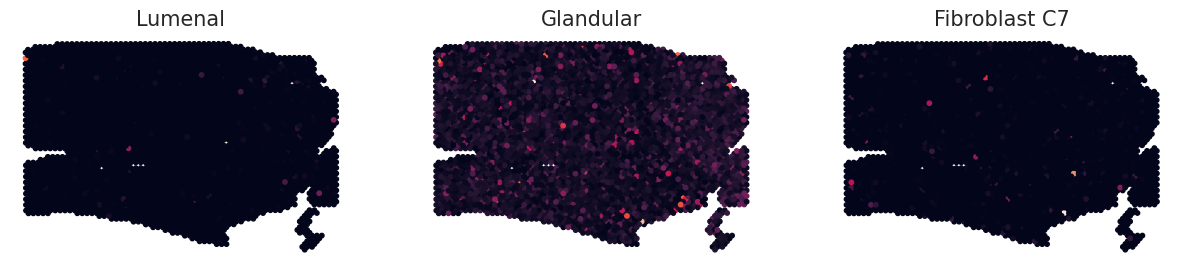

<Figure size 432x288 with 0 Axes>

In [135]:
novosparc.pl.embedding(dataset_tissue, ct_test)

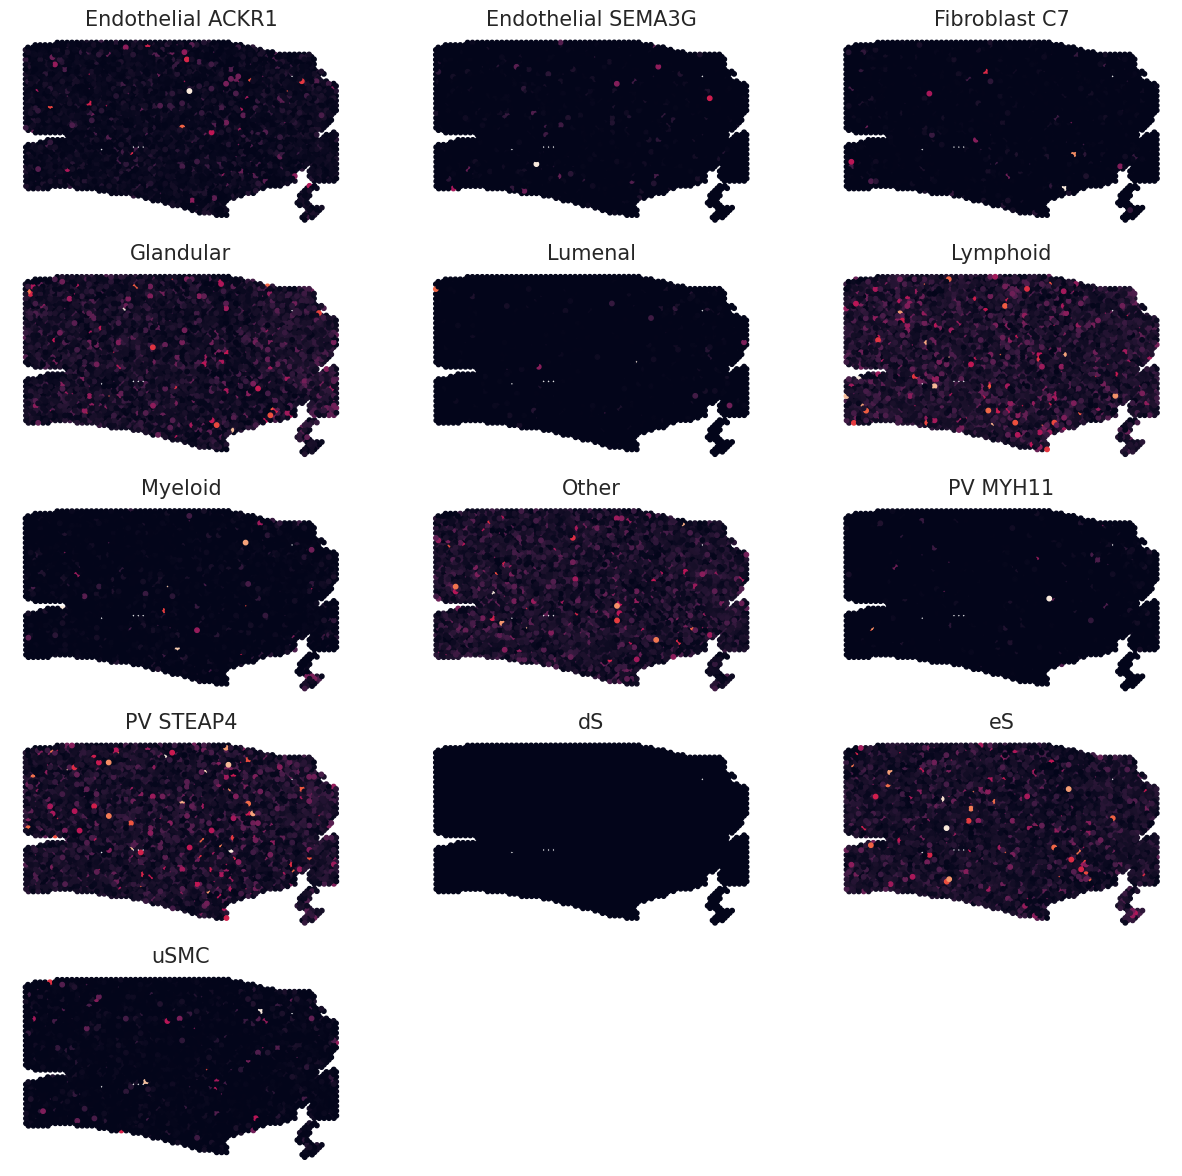

<Figure size 432x288 with 0 Axes>

In [136]:
novosparc.pl.embedding(dataset_tissue, ct_unique)

# data read in
## atlas and sc data

In [3]:
# atlas settings
atlas_dir = 'data'
target_space_path = os.path.join(atlas_dir, 'endometr_coordinates.txt')
locations = pd.read_csv(target_space_path, sep='\t')

num_locations = 3871 # coming from the spatial data
locations_apriori = locations[:num_locations][['x', 'y']]
locations = np.asarray(locations_apriori)

atlas_path = os.path.join(atlas_dir, 'uterus_GarciaAlsonso_atlas_spatial_info_dge.csv')
# atlas = sc.read_csv(atlas_path, delimiter=',') # this always through a Value Error about unmatching column numbers - idea why

chunks = pd.read_csv(atlas_path, index_col=0, chunksize=1000000)
df = pd.concat(chunks)
atlas = sc.AnnData(df)
atlas_genes = atlas.var.index.tolist()
atlas.obsm['spatial'] = locations

# Reading expression data to scanpy AnnData (cells x genes)
data_dir = 'data/'
data_path = os.path.join(data_dir, 'adata_ti_sec_2_sample_normalized_dge.csv')
dataset = sc.read(data_path).T
gene_names = dataset.var.index.tolist()
num_cells, num_genes = dataset.shape
print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)

/tmp/ipykernel_508185/2991384368.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  atlas = sc.AnnData(df)
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


number of cells: 2368
number of genes: 28614


# meta data

In [17]:
meta_data_dir = 'data'
meta_ct_path = os.path.join(meta_data_dir, "endo_sec2_celltype.csv")

cell_types_raw = pd.read_csv(meta_ct_path)
cell_type = np.asarray(cell_types_raw)

# Reconstruction
## create tissue object

In [10]:
# calculate cost matrix
# params for smooth cost # only needed when/for the part where you don't use the atlas!
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(gene_names))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)


# setup smooth
num_neighbors_s = num_neighbors_t = 5

# alternative 1: setup both assumptions
tissue.setup_reconstruction(atlas_matrix=atlas_matrix,
                            markers_to_use=markers_to_use,
                            num_neighbors_s=num_neighbors_s,
                            num_neighbors_t=num_neighbors_t)

# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

Setting up for reconstruction ... 

/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


done ( 15.52 seconds )
Reconstructing spatial information with 77 markers: 2368 cells and 3871 locations ... 
Trying with epsilon: 5.00e-03
Trying with epsilon: 5.00e-03


# meta data transfer
## prepare gw matrix

In [25]:
gw_matrix = pd.DataFrame(tissue.gw)
type(gw_matrix)
gw_matrix.shape[0]

2368

Assumption: cell type assignment is a binary mapping.
Therefor for each cell I only want the location with the highest probability - the rest 0.

Later I will encode the cell types as integers.
Then I can multiply the ct_int_matrix with the highest_probability_gw_matrix.
But then?

**Create highest probability matrix**
1. init a dic for index:value
2. iterate through the rows - identify highest value --> write value and index in dic
3. all zero gw
```
for col in df.columns:
    df[col].values[:] = 0
```
4. fill back the values from the dictionary `df.loc[0:15,'A'] = 16`

or
1. make all-0 df of the same size as gw
2. iterate through rows of gw
3. get max value
4. get index of max value
5. replace 0 in new df at same index with that value

In [50]:
# make all-0 df of the same size as gw
all_0_df = pd.DataFrame(
             np.zeros(shape=(gw_matrix.shape[0],gw_matrix.shape[1])))

# iterate through rows of gw
# ToDo there must be a vectorized way to do this
# or also in this directory manner like with the GMM function?
for row in gw_matrix.index:
    max_value = max(gw_matrix.loc[row])
    index_value = np.where( gw_matrix == max_value)
    # fill new df
    all_0_df.loc[int(index_value[0]),int(index_value[1])] = max_value

In [56]:
# every column must have a max value that is non 0 too now - no?
for (columnName, columnData) in all_0_df.iteritems():
        print(max(columnData))

# wait - has max() a decimal limit??

2.6187311234485275e-05
0.0
2.0551111814650404e-05
0.0
4.943980676301439e-05
0.0
0.0
0.0
0.0
0.0
1.8372474922781833e-05
0.0
4.238846023759693e-05
0.0
3.270045391467306e-05
0.0
3.117422613837353e-05
0.0
0.0
0.00014679845535993383
0.0
0.0
3.096544076153837e-05
0.0
0.0
0.00010115893924672853
6.204565214331501e-05
3.940741710287127e-05
0.0
0.0
7.7492445411775e-05
9.45877402097568e-05
9.201635815928516e-05
5.808988599157657e-05
0.0
0.0
5.7717225780959124e-05
1.8622938709799523e-05
0.0
5.8908832005311556e-05
8.754343663811775e-05
5.3380132972353594e-05
3.399210584415066e-05
0.0
0.00011111411854161928
0.0
0.0
5.123470772374493e-05
2.6781320169256274e-05
4.99623507710557e-05
5.5914628978404354e-05
0.0
0.0
0.0
2.698527539720279e-05
0.0
3.900944920743864e-05
0.0
2.1792317034709728e-05
9.420341633545701e-05
7.542230728126677e-05
0.0001160287602274258
0.00012148993789183287
0.0
0.0
4.6751106400415795e-05
3.076847283082434e-05
5.4278867251429604e-05
0.0
0.0
6.72601474258551e-05
0.0001407369799083158

## meta data mapped to location (?)

In [18]:
cell_types

,Cell type
0,dS
1,dS
2,dS
3,dS
4,dS
...,...
2363,Other
2364,dS
2365,dS
2366,eS


In [16]:
meta_data_map = np.dot(cell_types_arr.T, gw_matrix)

TypeError: can't multiply sequence by non-int of type 'float'

In [14]:
type(cell_types)

pandas.core.frame.DataFrame